# 1. Setup and Load Data
**1.1 Install Dependencies and Setup**

In [1]:
%%writefile requirements.txt
tensorflow
opencv-python
matplotlib
numpy
scikit-learn
pillow

Overwriting requirements.txt


In [2]:
!pip install -r requirements.txt


In [3]:
import tensorflow as tf
print(tf.__version__)


2.19.0


In [4]:
%pip install tensorflow opencv-python matplotlib

In [5]:
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
absolufy-imports                      0.3.1
accelerate                            1.10.0
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.12.15
aiosignal                             1.4.0
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.2
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.10.0
anywidget                             0.9.18
argon2-cffi                           25.1.0
argon2-cffi-bindings                  25.1.0
array_record                          0.7.2
arviz                                 0.22.0
astro

In [6]:
import tensorflow as tf
import os

In [7]:
# Avoid OOM errors by limiting GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
tf.config.list_physical_devices ('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**1.2 Remove dodgy images**

In [9]:
import cv2
import imghdr
from matplotlib import pyplot as plt

/tmp/ipython-input-3427753027.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [10]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = "/content/drive/MyDrive/data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os

root_dir = 'ruta/dataset'

# Eliminar .DS_Store si existe en cualquier carpeta
for root, dirs, files in os.walk(root_dir):
    if '.DS_Store' in files:
        os.remove(os.path.join(root, '.DS_Store'))


In [12]:
os.listdir(data_dir)

['paper',
 'metal',
 'organic',
 'cardboard',
 'e-waste',
 'trash',
 'glass',
 'plastic']

In [13]:
image_exts = ['jpeg', 'jpg', 'png', 'bmp', 'webp', 'gif']

In [14]:
!find /content/drive/MyDrive/data -name ".DS_Store" -delete

In [ ]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [21]:
img = cv2.imread("/content/drive/MyDrive/data/trash/trash_20237.jpg")

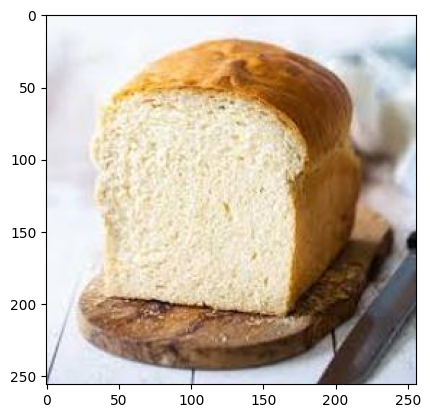

In [22]:
plt.imshow(cv2.cvtColor (img, cv2.COLOR_BGR2RGB))
plt.show()

**1.3 Load data**

In [23]:
import numpy as np
from matplotlib import pyplot as plt

In [26]:
import os
print(os.listdir("/content/drive/MyDrive/data"))

['paper', 'metal', 'organic', 'cardboard', 'e-waste', 'trash', 'glass', 'plastic']


In [29]:
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(256, 256),
    batch_size=32,
    shuffle=True
)



Found 15978 files belonging to 8 classes.


In [30]:
data_iterator = data.as_numpy_iterator()

In [31]:
# get another batch from the iterator
batch = data_iterator.next()

In [32]:
# 0=BAUHAUS 1=BRUTALISM 2=MINIMALIST
batch[1]

array([6, 4, 4, 0, 2, 0, 0, 7, 6, 5, 6, 5, 0, 1, 7, 7, 5, 4, 0, 5, 0, 7,
       6, 3, 6, 5, 7, 7, 2, 7, 0, 7], dtype=int32)

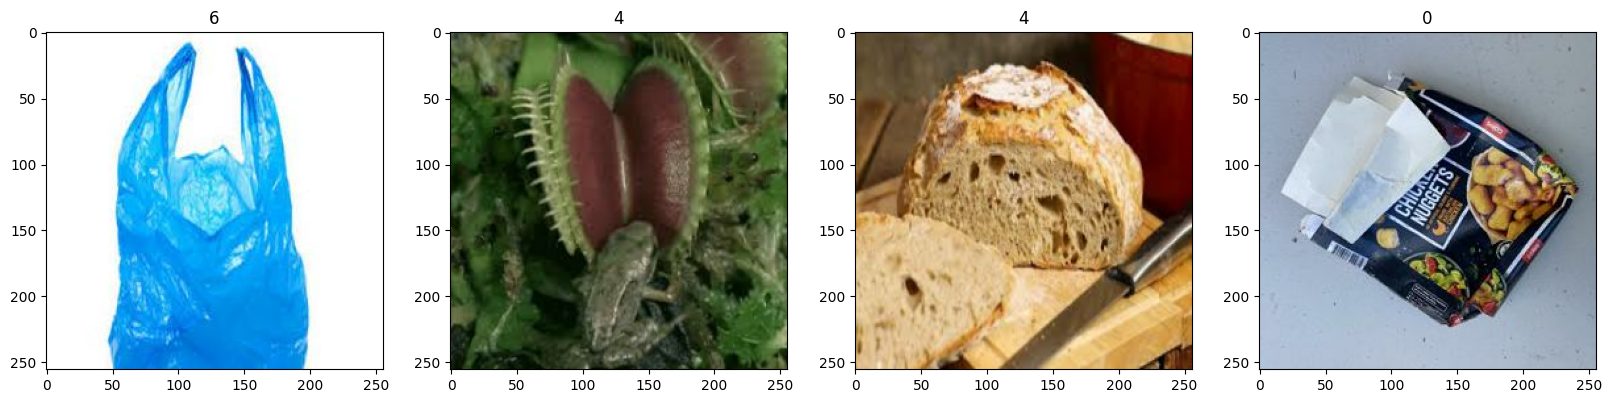

In [33]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 2. Process Data
**2.1 Scale Data**

In [34]:
data = data.map(lambda x, y: (x/255, y))

In [35]:
scaled_iterator = data.as_numpy_iterator()

In [36]:
batch = scaled_iterator.next()

In [37]:
batch[0].max()

np.float32(1.0)

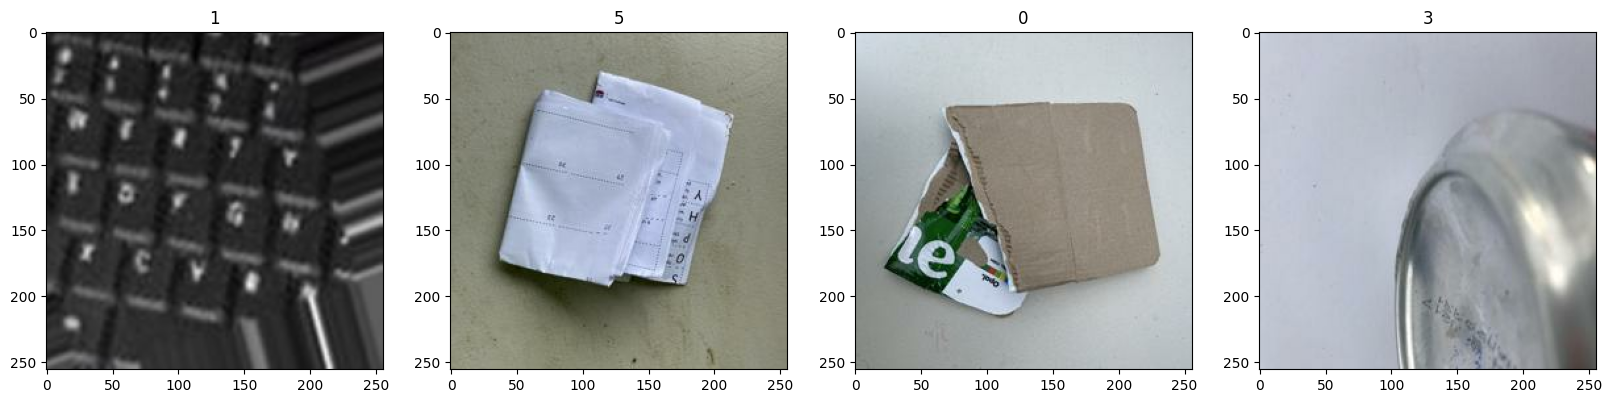

In [38]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

**2.2 Split Data into Training and Testing**

In [39]:
len(data)

500

In [42]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [43]:
train_size + val_size + test_size

500

In [44]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 3. Deep Model
**3.1 Build Deep Learning model**

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [46]:
model = Sequential()

In [47]:
# Bloque 1
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

# Bloque 2
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D())

# Bloque 3
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

# Capa densa
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Previene sobreajuste

# Salida para 8 clases
model.add(Dense(8, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # O categorical_crossentropy según tus labels
              metrics=['accuracy'])

In [49]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,586,760 (112.86 MB)

 Trainable params: 29,586,760 (112.86 MB)

 Non-trainable params: 0 (0.00 B)

**3.2 Train**

In [50]:
logdir='logs'

In [51]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [52]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1422s 4s/step - accuracy: 0.2456 - loss: 2.0754 - val_accuracy: 0.4294 - val_loss: 1.5936
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 86s 247ms/step - accuracy: 0.4793 - loss: 1.4710 - val_accuracy: 0.6003 - val_loss: 1.1598
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 75s 214ms/step - accuracy: 0.5979 - loss: 1.1532 - val_accuracy: 0.6319 - val_loss: 1.0985
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 75s 214ms/step - accuracy: 0.7012 - loss: 0.8728 - val_accuracy: 0.6378 - val_loss: 1.0762
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 75s 215ms/step - accuracy: 0.7710 - loss: 0.6588 - val_accuracy: 0.6875 - val_loss: 0.9916
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 74s 212ms/step - accuracy: 0.8308 - loss: 0.5050 - val_accuracy: 0.7022 - val_loss: 1.1137
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 76s 217ms/step - accuracy: 0.8727 - loss: 0.3951 - val_accuracy: 0.7219 - val_loss: 1.1190
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 78s 205ms/step - accuracy: 0.8955 - loss: 0.

**3.3 Plot Performance**

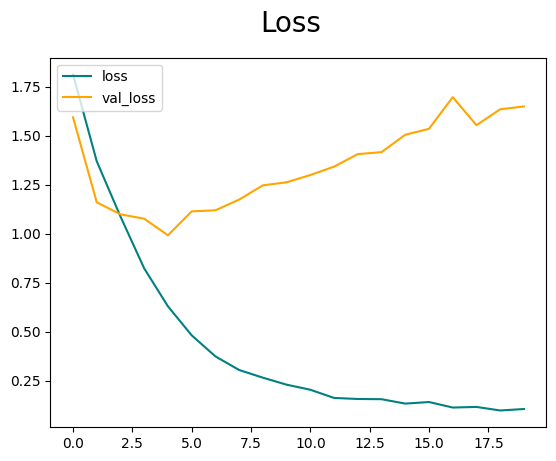

In [53]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

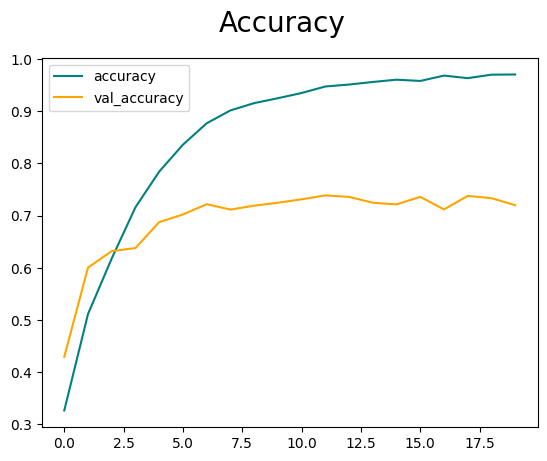

In [54]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 4. Evaluate Performance

In [55]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [56]:
precision = Precision()
recall = Recall()
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [57]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)

    # Obtener clases predichas (índice del valor más alto)
    yhat_classes = np.argmax(yhat, axis=1)

    # Actualizar métricas con clases predichas e ideales
    precision.update_state(y, yhat_classes)
    recall.update_state(y, yhat_classes)
    accuracy.update_state(y, yhat)  # SparseCategoricalAccuracy sí acepta logits softmax

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━

In [58]:
print(f'Precission: {precision.result().numpy()}, Recall:{recall.result().numpy()},Accuracy:{accuracy.result().numpy()}')

Precission: 0.9582400918006897, Recall:0.9504438042640686,Accuracy:0.6983523368835449


# 5.Test

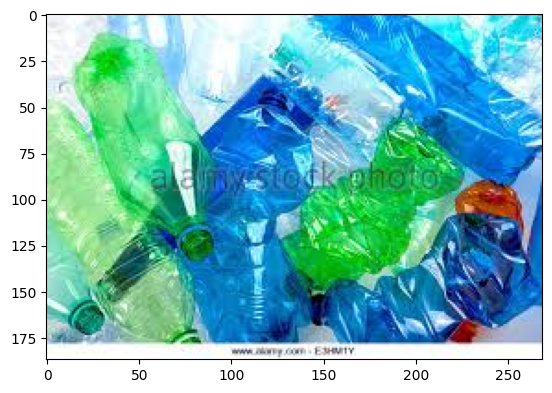

In [94]:
img = cv2.imread("/content/drive/MyDrive/test_data/plastic2.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

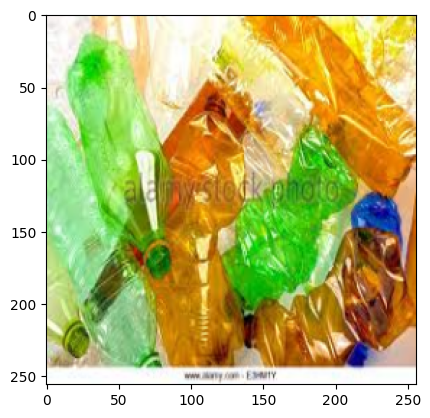

In [95]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()


In [96]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [97]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [98]:
yhat

array([[5.9709650e-06, 2.9682683e-06, 5.9369446e-05, 1.7110553e-07,
        8.0215102e-01, 8.8655201e-11, 2.0790233e-07, 1.9778037e-01]],
      dtype=float32)

In [99]:
predicted_class = np.argmax(yhat[0])  # usa [0] porque yhat es un batch
class_names = ['cardboard', 'e-waste', 'glass', 'metal', 'organic', 'paper', 'plastic', 'trash']
print(f'Predicted class is {class_names[predicted_class]}')
print(f'Probabilities: {yhat[0]}')


Predicted class is organic
Probabilities: [5.9709650e-06 2.9682683e-06 5.9369446e-05 1.7110553e-07 8.0215102e-01
 8.8655201e-11 2.0790233e-07 1.9778037e-01]
